In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/thesis/models')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from utility import process_md_lines

In [ ]:
training_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/training.txt','r',encoding='utf-8').readlines()
testing_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/testing.txt','r',encoding='utf-8').readlines()
validation_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/validation.txt','r',encoding='utf-8').readlines()

In [ ]:
training_df = process_md_lines(training_lines)
testing_df = process_md_lines(testing_lines)
validation_df = process_md_lines(validation_lines)

In [ ]:
training_df.head()

,id,text,order,total_lines,url,label
0,290,الشريان الأبهر هو أكبر شريان في الجسم وهو ينقل...,0,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
1,290,بشكل عام يكون تضيق الأبهر موجودا لدى المصاب من...,1,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
2,290,وغالبا ما يصاحب تضيق الأبهر عيوب أخرى في القلب...,2,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
3,290,تعتمد أعراض تضيق الأبهر على شدة الحالة فمعظم ا...,3,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms
4,290,قد يبدأ ظهور الأعراض على الأطفال المصابين بتضي...,4,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms


In [ ]:
tclasses = training_df['label'].unique()
no_classes = len(tclasses)
no_classes

5

In [ ]:
unique_orders = len(training_df['order'].unique()) # sentences count in the longest abstract
unique_orders

256

In [ ]:
unique_total_lines = len(training_df['total_lines'].unique())
unique_total_lines

168

In [ ]:
''' df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7) '''
train_df = training_df
test_df = testing_df

In [ ]:
X_sen_train = train_df['text'].to_numpy()
X_sen_test = test_df['text'].to_numpy()
X_sen_validation = validation_df['text'].to_numpy()

In [ ]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()
y_validation = pd.get_dummies(validation_df['label']).to_numpy()

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
X_char_train = [split_chars(sentence) for sentence in X_sen_train]
X_char_test = [split_chars(sentence) for sentence in X_sen_test]
X_char_validation = [split_chars(sentence) for sentence in X_sen_validation]

In [ ]:
train_orders_one_hot = tf.one_hot(train_df['order'].to_numpy(), depth=unique_orders)
test_orders_one_hot = tf.one_hot(test_df['order'].to_numpy(), depth=unique_orders)
validation_orders_one_hot = tf.one_hot(validation_df['order'].to_numpy(), depth=unique_orders)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=unique_total_lines)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=unique_total_lines)
validation_total_lines_one_hot = tf.one_hot(validation_df['total_lines'].to_numpy(), depth=unique_total_lines)

In [ ]:
vocab = set()
count = 0
char_count = 0
for text in train_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)
    
for text in test_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

In [ ]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

69150

In [ ]:
tokens_lens = [len(sentence.split()) for sentence in train_df['text'].to_numpy()]
WORD_SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
WORD_SEQ_LENGTH

49

In [ ]:
char_lens = [len(sentence) for sentence in train_df['text'].to_numpy()]
CHAR_SEQ_LENGTH = int(np.percentile(char_lens, 95))
CHAR_SEQ_LENGTH

284

In [ ]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 300

In [ ]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=WORD_SEQ_LENGTH)

In [ ]:
text_vectorizer.adapt(train_df['text'].to_numpy())

In [ ]:
''' embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
) '''

' embedding = tf.keras.layers.Embedding(\n    VOCAB_SIZE,\n    WORD_EMBED_SIZE,\n    mask_zero=True\n) '

In [ ]:
from tqdm.auto import tqdm
from keras.initializers import Constant
from gensim.models.keyedvectors import KeyedVectors

def prepare_embedding_index(embedding_name):
    embeddings_index = {}
    if embedding_name == 'Glove':
        f = open('/content/drive/MyDrive/hamdan/embeddings/glove/vocab.txt')
        #embedding_dim = 200
    if embedding_name == 'fastText':
        f = open('/content/drive/MyDrive/thesis/models/cc.ar.300.vec')
        #embedding_dim = 300
    #elif embedding_name == 'AraVec':
        #f = gensim.models.Word2Vec.load('/content/full_grams_cbow_300_twitter.mdl')
        #embedding_dim = 300
        
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    return embeddings_index, WORD_EMBED_SIZE


def prepare_embedding_matrix(embeddings_index, embedding_dim, VOC_SIZE, tokenizer):
    count_known = 0
    count_unknown = 0
        
    embedding_matrix = np.zeros((VOC_SIZE, embedding_dim))

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= VOC_SIZE:
            continue
        embedding_vector = None
        try:
            embedding_vector = embeddings_index[word]
        except:
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            count_known += 1
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
            count_unknown += 1

    print(f'{count_known} known vectors\n{count_unknown} random vectors') 
    return embedding_matrix

In [ ]:
#x_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE) 
#x_tokenizer.fit_on_texts(df['text'].to_numpy())
#embedding_matrix = prepare_embedding_matrix(*prepare_embedding_index('fastText'), VOC_SIZE=VOCAB_SIZE+1, tokenizer=x_tokenizer)
#word_embedding = layers.Embedding(VOCAB_SIZE, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix),input_length=WORD_SEQ_LENGTH, trainable=True)

In [ ]:
word_embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [ ]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens= NUM_CHAR_TOKENS,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=CHAR_SEQ_LENGTH
)

In [ ]:
text_chars = [" ".join(list(sentence)) for sentence in train_df['text'].to_numpy()]
char_vectorizer.adapt(text_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'ا', 'ل', 'ي']
5 least common characters: ['x', 'w', 'k', '6', '—']


In [ ]:
char_embedding = tf.keras.layers.Embedding(
    NUM_CHAR_TOKENS,
    25,
    mask_zero=False
)

In [ ]:
# 1. Setup token inputs/model
word_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
word_vectors = text_vectorizer(word_inputs)
word_embeddings = word_embedding(word_vectors)
#xx = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(word_embeddings)
#word_output = layers.GlobalAveragePooling1D()(xx)
xx = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(word_embeddings)
xx = layers.Dropout(0.2)(xx)
word_output = layers.Bidirectional(layers.LSTM(64))(xx)
word_model = tf.keras.Model(inputs=word_inputs, outputs=word_output)

In [ ]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_output = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_output)

In [ ]:
# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(unique_orders,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

In [ ]:
# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(unique_total_lines,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

In [ ]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([word_model.output, 
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [ ]:
# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

In [ ]:
# 7. Create output layer
#o1 = layers.Dense(512, activation="relu")(z)
#o2 = layers.Dense(256, activation="relu")(o1)
#o3 = layers.Dense(128, activation="relu")(o2)
output_layer = layers.Dense(no_classes, activation="softmax", name="output_layer")(z)

In [ ]:
# 8. Put together model
model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 word_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 49)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 embedding_3 (Embedding)        (None, 49, 300)      20745000    ['text_vectorization[0][0]']     
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                         

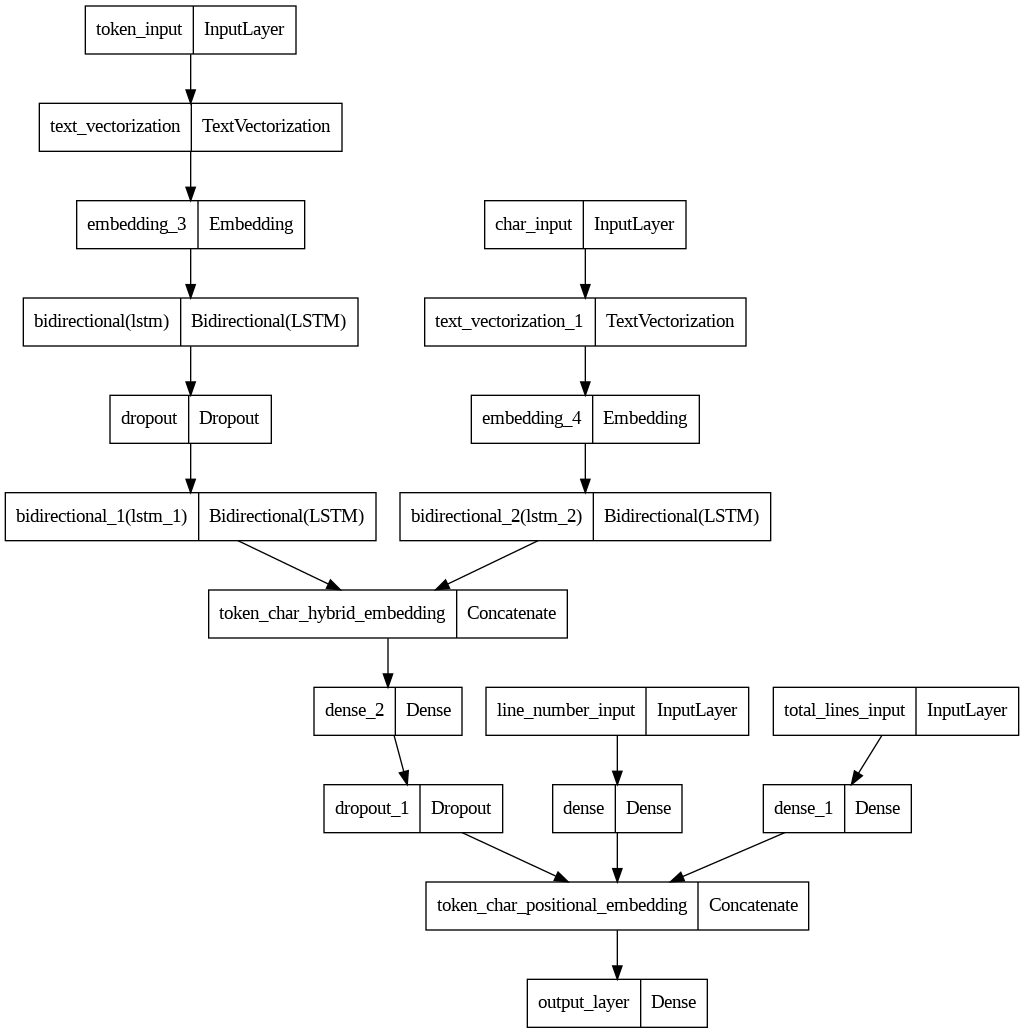

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_orders_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                X_sen_train, # train tokens
                                                                X_char_train)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_orders_one_hot,
                                                              test_total_lines_one_hot,
                                                              X_sen_test,
                                                              X_char_test))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [ ]:

# Check input shapes
train_pos_char_token_dataset, test_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None, 168), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None, 168), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.uint8, name=None))>)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=50,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

lrc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

def create_chk(filename):
    chk = tf.keras.callbacks.ModelCheckpoint(
    filename,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None)
    return chk

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=["accuracy"])

In [ ]:
model.fit(train_pos_char_token_dataset, validation_data=test_pos_char_token_dataset, epochs=10)

Epoch 1/10
9273/9273 [==============================] - 684s 71ms/step - loss: 0.3875 - accuracy: 0.8732 - val_loss: 0.2051 - val_accuracy: 0.9345
Epoch 2/10
9273/9273 [==============================] - 662s 71ms/step - loss: 0.1381 - accuracy: 0.9560 - val_loss: 0.1226 - val_accuracy: 0.9608
Epoch 3/10
9273/9273 [==============================] - 665s 72ms/step - loss: 0.0783 - accuracy: 0.9749 - val_loss: 0.1010 - val_accuracy: 0.9713
Epoch 4/10
9273/9273 [==============================] - 660s 71ms/step - loss: 0.0556 - accuracy: 0.9819 - val_loss: 0.0958 - val_accuracy: 0.9745
Epoch 5/10
9273/9273 [==============================] - 658s 71ms/step - loss: 0.0432 - accuracy: 0.9859 - val_loss: 0.0822 - val_accuracy: 0.9798
Epoch 6/10
9273/9273 [==============================] - 655s 71ms/step - loss: 0.0361 - accuracy: 0.9881 - val_loss: 0.0887 - val_accuracy: 0.9807
Epoch 7/10
9273/9273 [==============================] - 654s 71ms/step - loss: 0.0322 - accuracy: 0.9895 - val_loss: 0

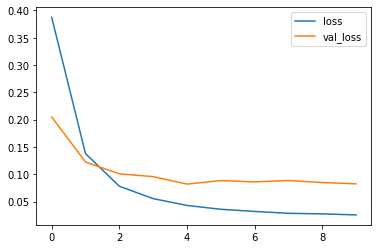

In [ ]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [ ]:
model.evaluate(test_pos_char_token_dataset)

1142/1142 [==============================] - 27s 24ms/step - loss: 0.0827 - accuracy: 0.9843


[0.08267819881439209, 0.9843112826347351]

In [ ]:
#Test Dataset (10%)
preds = np.argmax(model.predict(test_pos_char_token_dataset), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_test, cat_preds))

1142/1142 [==============================] - 32s 22ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6114
           1       0.99      0.99      0.99      6152
           2       0.97      0.99      0.98      3572
           3       0.97      0.99      0.98      7663
           4       1.00      0.99      0.99     13022

   micro avg       0.98      0.98      0.98     36523
   macro avg       0.98      0.98      0.98     36523
weighted avg       0.98      0.98      0.98     36523
 samples avg       0.98      0.98      0.98     36523



In [ ]:
r = np.random.randint(0,len(X_sen_test))
text = X_sen_test[r]
true_pred = y_train[r]
print("text:", text)
true_pred_ = np.argmax(true_pred)
print("True Label", true_pred_)



text: إذا اعتقد طبيبك أن جلطة من جزء آخر من الجسم تسببت في الانسداد فقد يقترحون اختبارات أخرى للبحث عن مشاكل في الشرايين والقلب وقد يطلبون أيضا إجراء اختبارات الدم للتحقق من اضطرابات التخثر ومستويات الكوليسترول لديك

True Label 4
